<img src="https://relevance.ai/wp-content/uploads/2021/11/logo.79f303e-1.svg" width="150" alt="Relevance AI" />
<h5> Developer-first vector platform for ML teams </h5>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RelevanceAI/workflows/blob/main/workflows/subclustering/basic_subclustering.ipynb)

# 🤖: Basic Sub-clustering

This notebook is a quick guide on how to use Relevance AI for subclustering. Subclustering allows users to infinitely drill down into their clusters by running more clusters.

Basic sub-clustering allows users to rely on clustering in simple ways.

For more details, please refer to the  [references](https://relevanceai.readthedocs.io/en/development/operations/cluster/subclustering.html).


In [ ]:
!pip install -q RelevanceAI[notebook]

In [ ]:
from relevanceai import Client

"""
You can sign up/login and find your credentials here: https://cloud.relevance.ai/sdk/api
Once you have signed up, click on the value under `Authorization token` and paste it here
"""

client = Client()

# 🚣 Inserting data

We use a sample ecommerce dataset - with vectors `product_image_clip_vector_` and `product_title_clip_vector_` already encoded for us.

In [ ]:
from relevanceai.utils.datasets import get_ecommerce_dataset_encoded

docs = get_ecommerce_dataset_encoded()
docs[0].keys()


In [ ]:
ds = client.Dataset('basic_subclustering')
ds.delete()
ds.upsert_documents(docs)

In [ ]:
ds.schema

In [ ]:
vector_fields = ds.list_vector_fields()
vector_fields

# 🍒  Running the initial clustering approach:

In [ ]:

"""
Let's instanatiate a clustering model and set an appropriate parent alias for n_clusters
Let's vectorize over all available vector fields
"""

n_clusters = 10
vector_field = "product_image_clip_vector_"
parent_alias = f"kmeans_{n_clusters}"

from sklearn.cluster import KMeans
model = KMeans(n_clusters=n_clusters)

for v in vector_fields:
  cluster_ops = ds.cluster(
    model,
    vector_fields=[v],
    alias=parent_alias
  )

ds.schema

In [ ]:

"""
You can find the parent field in the schema or alternatively provide a field
"""

parent_field = f"_cluster_.{vector_field}.{parent_alias}"


If we have a look at the resulting clusters in the [clustering dashboard link above](https://cloud.relevance.ai/dataset/basic_subclustering/deploy/recent/cluster/), we will see that there is potential for further break down the clusters. At a high-lvel, we can see electronics and shoes, but we could further break down these clusters using subclustering filter.





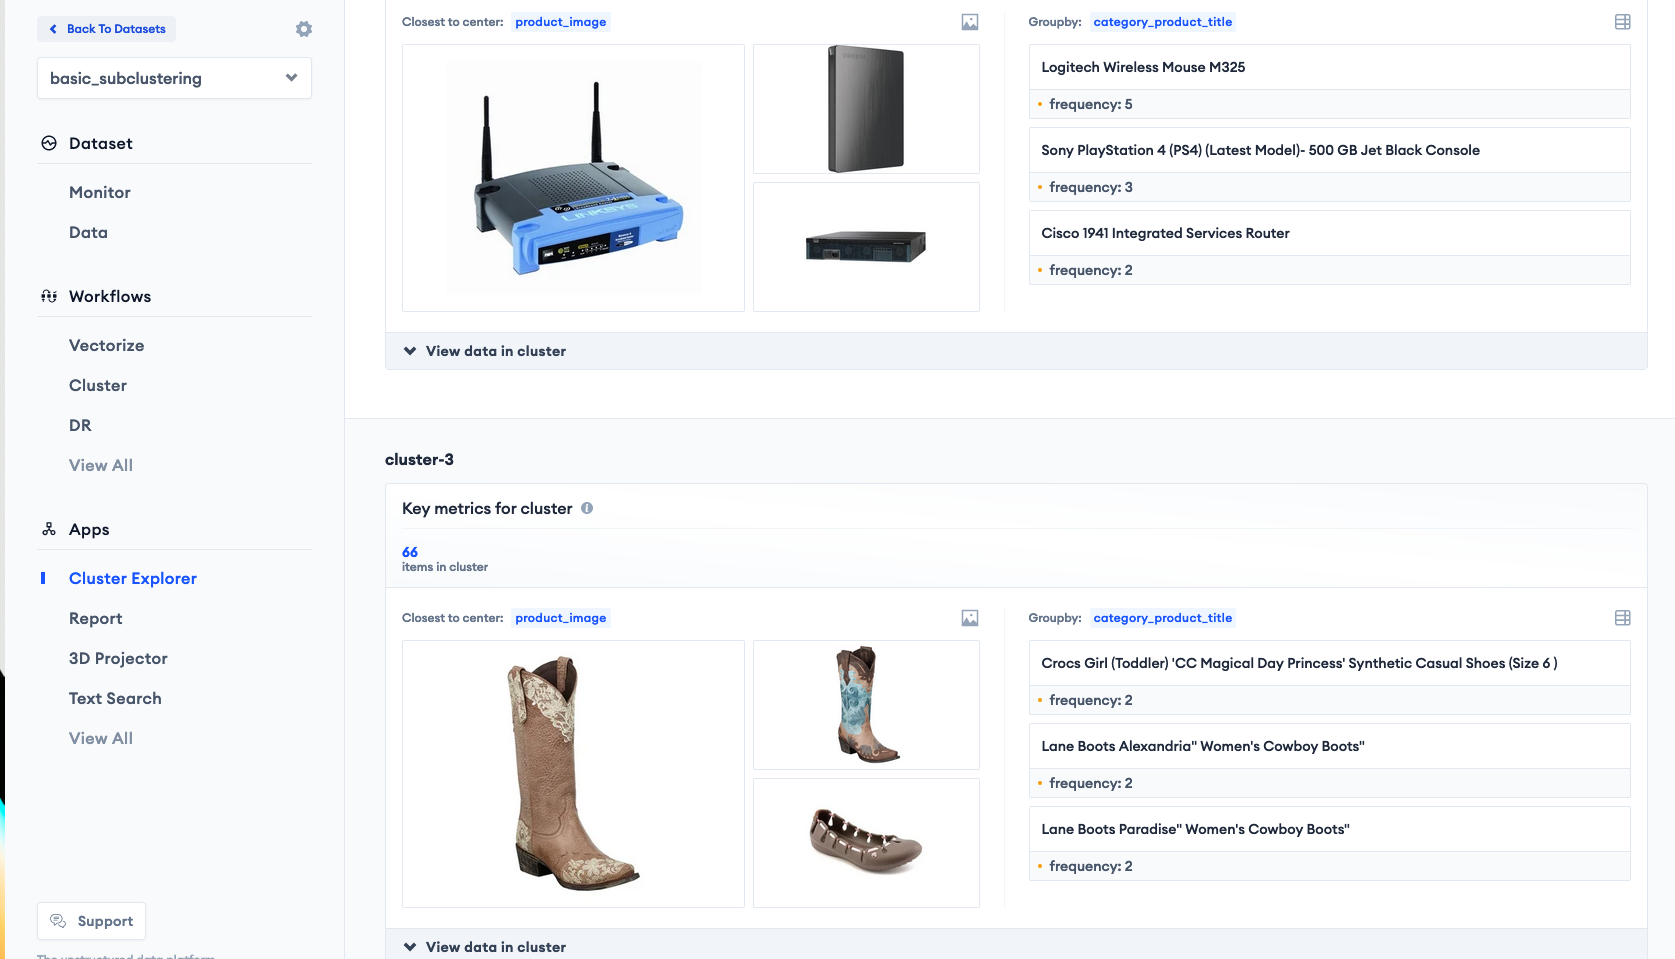

# 🫐 Running sub-clustering is then as simple as running **ds.subcluster** to the function.

In [ ]:

vector_field = "product_image_clip_vector_"

"""
Given the parent field - we now run subclustering 
Let's dive deeper to view 3 subclusters 
"""

subcluster_n_clusters = 3
subcluster_alias = f"{parent_alias}_{subcluster_n_clusters}"

from sklearn.cluster import KMeans
model = KMeans(n_clusters=subcluster_n_clusters)

ds.subcluster(
   model=model,
   parent_field=parent_field,
   vector_fields=[vector_field],
   alias=subcluster_alias
)


In [ ]:

"""
We can see the new subcluster in the schema
"""

ds.schema


In [ ]:

"""
# You should also be able to track your subclusters using
"""

ds.metadata


In [ ]:
# You can also view your subcluster results using
subcluster_field = f"_cluster_.{vector_field}.{subcluster_alias}"

ds[subcluster_field] 

In [ ]:

"""
View dataset health
"""
ds.health()

# 🧐 Looking into our subclusters

In [ ]:

"""
Let's build a subcluster lookup to help us further analyze our clusters
# subclusters = 
# {
#  'parent_cluster_id': {
#     'subcluster_': [subcluster_docs]
# }, ...
"""


from collections import defaultdict
from pprint import pprint

def build_subcluster_lut(ds, vector_field, parent_alias, subcluster_alias):
  ## Let's retrieve our docs again with the new subcluster field
  docs = ds.get_all_documents(include_vector=False)  
  subclusters=defaultdict(dict)
  doc_fields =[k for k in ds.schema.keys() if '.' not in k if not any([f in k for f in ["_vector_",  "insert_date_"]])]

  for d in docs:
    parent_cluster = d['_cluster_'][vector_field][parent_alias]
    subcluster = d['_cluster_'][vector_field][subcluster_alias]
    doc = { k:v for k, v in d.items() if k in doc_fields } 
    subclusters[parent_cluster].setdefault(subcluster, []).append(doc)
  return subclusters

subclusters_3 = build_subcluster_lut(ds, vector_field, parent_alias, subcluster_alias)


In [ ]:
from relevanceai import show_json
from random import sample


def get_subcluster(subclusters, cluster_id, subcluster_ids=[]):
  if not subcluster_ids:
    subcluster_ids=list(subclusters[cluster_id].keys())
  return {k:v for k, v in subclusters[cluster_id].items() if k in subcluster_ids}


def search_subclusters(subclusters, cluster_id,  subcluster_id=None, n_docs=10):
  docs=[]
  subcluster_ids=list(subclusters[cluster_id].keys()) if not subcluster_id else [subcluster_id]
  
  for subcluster_id in subcluster_ids:
    docs += get_subcluster(subclusters, cluster_id, subcluster_id)[subcluster_id]

  print(f'==========')
  print(f"Cluster: {cluster_id}")
  print(f"Subclusters: {' '.join(subcluster_ids)}")
  print(f'Displaying {n_docs} of {len(docs)} documents ... ')
  print(f'==========')

  display(
      show_json(sample(docs, n_docs),
      image_fields=['product_image'],
      text_fields=['query', 'product_title', 'product_price'],
    )
  )



"""
We can see from searching the cluster itself, we can see a mixtures of items in our cluster
"""

cluster_id = 'cluster-0'
search_subclusters(subclusters_3, cluster_id )

In [ ]:
"""
Subclustering allows us to further drill down into our clusters to find more well-defined grousp
"""

cluster_id = 'cluster-0'
subcluster_id = 'cluster-0-0'

print(f'Searching {subcluster_alias} in {vector_field} ...')

search_subclusters(subclusters_3, cluster_id, subcluster_id)

# 🍇 You can then run sub-clustering again on a separate parent alias!

If we find our intiail subclusters are insufficient, we can run subclustering again even more clusters to drill down down even furher.

You are also able to infinitely continue subclustering as required by constantly referring back to the parent alias.

In [ ]:
"""
Given the parent field - we now run subclustering 
Before, we subclustered on 3 subclusters
Let's dive even deeper to view 5 subclusters 
"""

subcluster_n_clusters = 5
subcluster_alias = f"{parent_alias}_{subcluster_n_clusters}"

from sklearn.cluster import KMeans
model = KMeans(n_clusters=subcluster_n_clusters)

ds.subcluster(
   model=model,
   parent_field=parent_field,
   vector_fields=[vector_field],
   alias=subcluster_alias
)

In [ ]:
ds.schema

In [ ]:
"""
Let's search again with 5 subclusters
"""
subclusters_5  = build_subcluster_lut(ds, vector_field, parent_alias, subcluster_alias)

print(f'Searching {subcluster_alias} in {vector_field} ...')

cluster_id = 'cluster-0'
search_subclusters(subclusters_5, cluster_id )


In [ ]:
"""
Let's search again with 5 subclusters
We can see comparatively, these results are even more finegrained than when subclustering with 3 subclusters
"""

cluster_id = 'cluster-0'
subcluster_id = 'cluster-0-0'

search_subclusters(subclusters_5, cluster_id , subcluster_id)



**Next steps**

If you require more indepth knowledge around subclustering, we will be writing more guides on how to adapt these to different aliases and models in the near future.


For more details, please refer to the  [references](https://relevanceai.readthedocs.io/en/development/operations/cluster/subclustering.html).